## Load data & quick peek

Let's load the cleaned dataset (`clean_credit_default_information.csv`) and preview the first few rows to confirm the schema and data types.  

From that we see the columns `X1` to `X23` plus the binary target `Y` are present. The values appear as expected, with no obvious parsing issues.


In [8]:
import pandas as pd

df = pd.read_csv('./data/clean_credit_default_information.csv')

df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Target distribution (Y) — class balance

Let's check the class balance for the target variable `Y` by counting the number of `0` (No Default) and `1` (Default) cases.  

From that we see there are about **23,335** non-defaulters and **6,630** defaulters, giving a default rate of roughly **22.1%** and a non-default rate of **77.9%**.  
This confirms the dataset is **imbalanced**, meaning accuracy alone would be a misleading metric.


In [9]:
df['Y'].value_counts()

Y
0    23335
1     6630
Name: count, dtype: int64

## Visualizing the target distribution

Let's plot a pie chart to visualize the distribution of defaulters vs non-defaulters.  

From that we see a clear dominance of the “No Default” class, visually confirming the ~78/22 split.  
This highlights the need for stratified sampling and evaluation metrics such as ROC-AUC, PR-AUC, and lift.


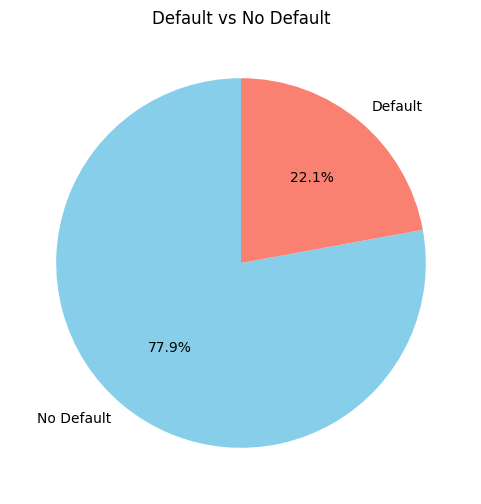

In [10]:
import matplotlib.pyplot as plt

counts = df['Y'].value_counts()
labels = ['No Default', 'Default'] 

plt.figure(figsize=(6, 6))

plt.pie(
    counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'salmon'],
)

plt.title("Default vs No Default")
plt.show()

## Random guessing baseline (accuracy)

Let's calculate the probability of being correct when randomly guessing outcomes according to the class priors. 

From that we see the baseline accuracy is **~65.5%**.  
This means any model evaluated purely on accuracy must comfortably exceed this figure to be considered useful.


In [11]:
counts = df['Y'].value_counts(normalize=True)
p0, p1 = counts[0], counts[1]

random_baseline = p0**2 + p1**2
print(f"Probability of guessing randomly and being correct -- Baseline: {random_baseline:.2%}")


Probability of guessing randomly and being correct -- Baseline: 65.54%


## Why a Lift chart?

Let's frame our evaluation in terms of **ranking**: sorting customers by predicted probability of default, and seeing how quickly we can capture the true defaulters.  

From that we see two reference curves:  

- **Random Baseline (Diagonal)**: captures defaulters at the same rate as sampling the population.  
- **Perfect Model**: captures **all** defaulters immediately, then flattens.

Our models should fall **between** these curves — the closer to the perfect model, the better the lift.


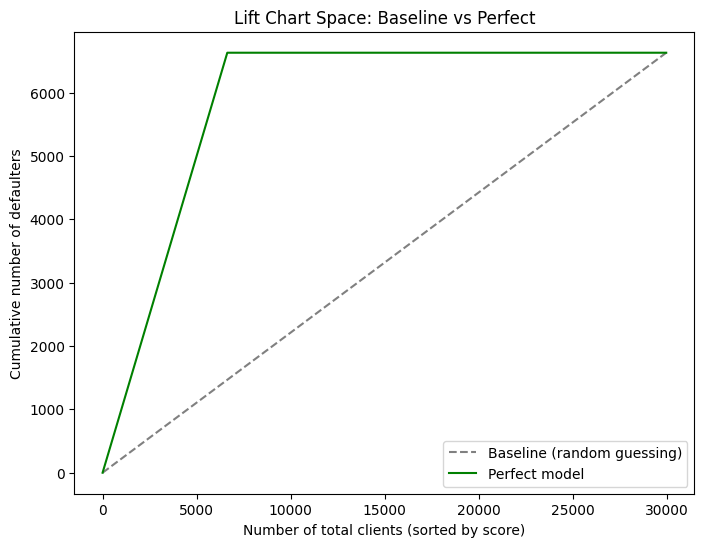

In [12]:
import numpy as np
import matplotlib.pyplot as plt


total = len(df)   
defaults = df['Y'].sum()    
default_rate = defaults / total 

# X-axis = fraction of population
x = np.linspace(0, 1, 100)

# Baseline random curve = diagonal
baseline_y = x * defaults

# Perfect model curve:
perfect_x = np.concatenate([
    np.linspace(0, defaults/total, 100),  # first part: find all defaulters
    np.linspace(defaults/total, 1, 100)   # rest of population (no new defaulters)
])
perfect_y = np.concatenate([
    np.linspace(0, defaults, 100),        # capture all defaulters quickly
    np.ones(100) * defaults               # then flat (no more)
])

plt.figure(figsize=(8,6))
plt.plot(x*total, baseline_y, label="Baseline (random guessing)", linestyle="--", color="gray")
plt.plot(perfect_x*total, perfect_y, label="Perfect model", color="green")

plt.xlabel("Number of total clients (sorted by score)")
plt.ylabel("Cumulative number of defaulters")
plt.title("Lift Chart Space: Baseline vs Perfect")
plt.legend()
plt.show()

## Lift chart space: Baseline vs Perfect (reference plot)

Let's plot the space for the Lift Chart, showing both the **random guessing baseline** and a **perfect model**.  

From that we see the X-axis represents the number of total clients (sorted by predicted score) and the Y-axis shows the cumulative number of defaulters captured.  
The **gap between the model’s curve and the random baseline** represents the lift.  
In later steps, we’ll overlay our model’s curve here to quantify lift@k, which is far more informative than accuracy in imbalanced classification.
